In [1]:
#
# Project 1, starter code part a
#
#import libraries
import math
import tensorflow as tf
import numpy as np
import pylab as plt
from sklearn import model_selection
import time

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

NUM_FEATURES = 21
NUM_CLASSES = 3
num_neurons = 10

no_folds = 5
learning_rate = 0.01
epochs = 10000
batch_size =32 
num_neurons =10 
seed = 10
beta = 10**-6 
np.random.seed(seed)

In [2]:
# generate training data
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
X_data, Y_data = train_input[1:, :21], train_input[1:,-1].astype(int)
X_data = scale(X_data, np.min(X_data, axis=0), np.max(X_data, axis=0))

# perform experiments
n = X_data.shape[0]
idx = np.arange(n)
np.random.shuffle(idx)
X_data, Y_data = X_data[idx],Y_data[idx]

#Experiment with small datasets\n",
sample_X = X_data[:200]
sample_Y_raw = Y_data[:200]
sample_Y = np.zeros((sample_Y_raw.shape[0], NUM_CLASSES))
sample_Y[np.arange(sample_Y_raw.shape[0]), sample_Y_raw-1] = 1 #one hot matrix


# Holdout Method

In [19]:
trainX, testX, trainY, testY = model_selection.train_test_split(sample_X,sample_Y, test_size=0.3, random_state=42) #split data

In [20]:
start_time = time.time()

x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

n = trainX.shape[0]

# Create the model

w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
b1  = tf.Variable(tf.zeros([num_neurons]), name='biases')
u1 = tf.matmul(x, w1) + b1
h1 = tf.nn.relu(u1)
w2 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(num_neurons)), name='weights')
b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
y = tf.matmul(h1, w2) + b2
        
# Build the graph for the deep net

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y)
regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) 
loss = tf.reduce_mean(cross_entropy+beta*regularization)
        
# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)
correct_prediction = tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)
        
# train
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    holdout_train_acc = []
    holdout_test_acc = []
    for i in range(epochs):
        for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
            train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
        holdout_train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
        holdout_test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        if i % 500 == 0:
            print('iter %d: train accuracy %g test accuracy %g'%(i, holdout_train_acc[i],holdout_test_acc[i]))   

#record time
    
end_time = time.time()
elapsed = end_time - start_time
print('Time elapsed: %d' %(elapsed))

iter 0: train accuracy 0.292857 test accuracy 0.266667
iter 500: train accuracy 0.807143 test accuracy 0.733333
iter 1000: train accuracy 0.835714 test accuracy 0.75
iter 1500: train accuracy 0.85 test accuracy 0.75
iter 2000: train accuracy 0.907143 test accuracy 0.766667
iter 2500: train accuracy 0.907143 test accuracy 0.783333
iter 3000: train accuracy 0.914286 test accuracy 0.766667
iter 3500: train accuracy 0.928571 test accuracy 0.783333
iter 4000: train accuracy 0.928571 test accuracy 0.783333
iter 4500: train accuracy 0.928571 test accuracy 0.783333
iter 5000: train accuracy 0.928571 test accuracy 0.75
iter 5500: train accuracy 0.942857 test accuracy 0.766667
iter 6000: train accuracy 0.935714 test accuracy 0.75
iter 6500: train accuracy 0.942857 test accuracy 0.75
iter 7000: train accuracy 0.942857 test accuracy 0.75
iter 7500: train accuracy 0.942857 test accuracy 0.766667
iter 8000: train accuracy 0.942857 test accuracy 0.766667
iter 8500: train accuracy 0.942857 test accura

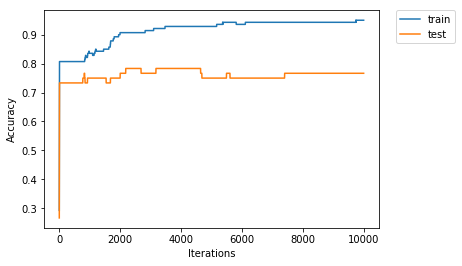

In [21]:
#plot

plt.figure(1)
plt.plot(range(epochs), holdout_train_acc,label="train")
plt.plot(range(epochs), holdout_test_acc,label="test")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()  

# 5-fold-cross-validation Method

In [24]:
#initialise 

fold_train_acc=np.zeros((no_folds,epochs))
fold_test_acc=np.zeros((no_folds,epochs))
X,Y = sample_X,sample_Y
start_time = time.time()

#iteration per fold
for fold in range(no_folds): 
    start, end = int(fold*len(X)/no_folds), int((fold+1)*len(X)/no_folds)
    testX, testY = X[start:end], Y[start:end]
    trainX  = np.append(X[:start], X[end:], axis=0)
    trainY = np.append(Y[:start], Y[end:], axis=0) 
        
        
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    n = trainX.shape[0]

    # Create the model

    w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
    b1  = tf.Variable(tf.zeros([num_neurons]), name='biases')
    u1 = tf.matmul(x, w1) + b1
    h1 = tf.nn.relu(u1)
    w2 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(num_neurons))), name='weights')
    b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
    y = tf.matmul(h1, w2) + b2

    # Build the graph for the deep net
	
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y)
    regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
    loss = tf.reduce_mean(cross_entropy + beta*regularization)
            
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)
    correct_prediction = tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
        
    # train
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        train_acc = []
        test_acc = []
        for i in range(epochs):
            for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
                train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
            train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
            test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
            if i % 500 == 0:
                print('iter %d: train accuracy %g test accuracy %g'%(i, train_acc[i],test_acc[i]))   
            
        fold_train_acc[fold] = train_acc
        fold_test_acc[fold] = test_acc

#record time        
end_time = time.time()
elapsed = end_time - start_time
print('Time elapsed: %d' %(elapsed))

iter 0: train accuracy 0.8 test accuracy 0.725
iter 500: train accuracy 0.8 test accuracy 0.725
iter 1000: train accuracy 0.875 test accuracy 0.775
iter 1500: train accuracy 0.89375 test accuracy 0.775
iter 2000: train accuracy 0.89375 test accuracy 0.8
iter 2500: train accuracy 0.90625 test accuracy 0.825
iter 3000: train accuracy 0.91875 test accuracy 0.825
iter 3500: train accuracy 0.91875 test accuracy 0.825
iter 4000: train accuracy 0.925 test accuracy 0.825
iter 4500: train accuracy 0.925 test accuracy 0.85
iter 5000: train accuracy 0.93125 test accuracy 0.875
iter 5500: train accuracy 0.93125 test accuracy 0.9
iter 6000: train accuracy 0.9375 test accuracy 0.9
iter 6500: train accuracy 0.9375 test accuracy 0.9
iter 7000: train accuracy 0.94375 test accuracy 0.9
iter 7500: train accuracy 0.94375 test accuracy 0.9
iter 8000: train accuracy 0.94375 test accuracy 0.9
iter 8500: train accuracy 0.94375 test accuracy 0.9
iter 9000: train accuracy 0.94375 test accuracy 0.875
iter 9500: 

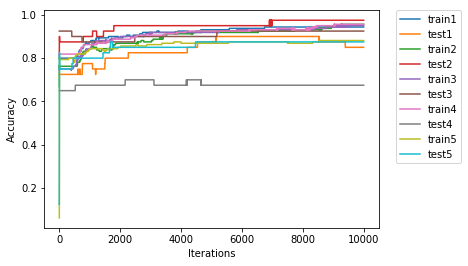

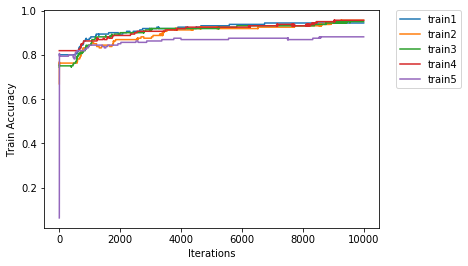

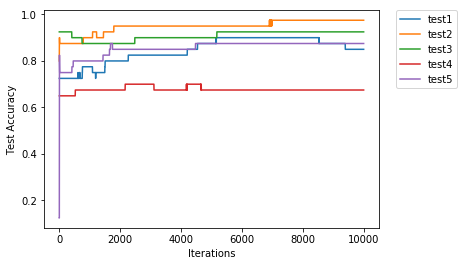

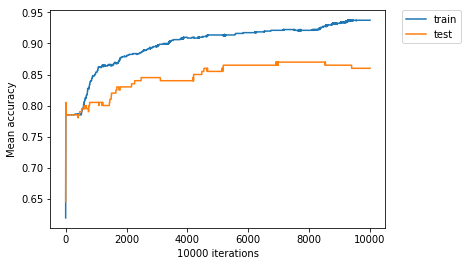

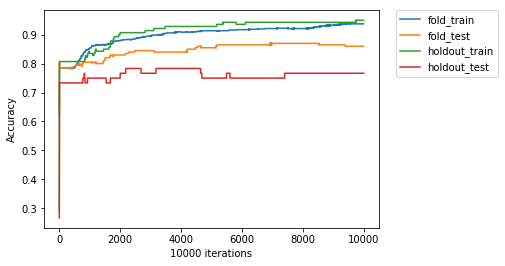

Fold train acc: 0.9375
Fold test acc 0.86
Holdout train acc: 0.95
Holdout test acc: 0.766667


In [30]:
# plot learning curves
        
plt.figure(2)
plt.plot(range(epochs), fold_train_acc[0],label="train1")
plt.plot(range(epochs), fold_test_acc[0],label="test1")
plt.plot(range(epochs), fold_train_acc[1],label="train2")
plt.plot(range(epochs), fold_test_acc[1],label="test2")
plt.plot(range(epochs), fold_train_acc[2],label="train3")
plt.plot(range(epochs), fold_test_acc[2],label="test3")
plt.plot(range(epochs), fold_train_acc[3],label="train4")
plt.plot(range(epochs), fold_test_acc[3],label="test4")
plt.plot(range(epochs), fold_train_acc[4],label="train5")
plt.plot(range(epochs), fold_test_acc[4],label="test5")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
        
plt.figure(3)
plt.plot(range(epochs), fold_train_acc[0],label="train1")
plt.plot(range(epochs), fold_train_acc[1],label="train2")
plt.plot(range(epochs), fold_train_acc[2],label="train3")
plt.plot(range(epochs), fold_train_acc[3],label="train4")
plt.plot(range(epochs), fold_train_acc[4],label="train5")
plt.xlabel('Iterations')
plt.ylabel('Train Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
        
plt.figure(4)
plt.plot(range(epochs), fold_test_acc[0],label="test1")
plt.plot(range(epochs), fold_test_acc[1],label="test2")
plt.plot(range(epochs), fold_test_acc[2],label="test3")
plt.plot(range(epochs), fold_test_acc[3],label="test4")
plt.plot(range(epochs), fold_test_acc[4],label="test5")
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

avg_fold_train_acc=np.mean(fold_train_acc, axis = 0)
avg_fold_test_acc=np.mean(fold_test_acc, axis = 0)
        
plt.figure(5)
plt.plot(range(epochs), avg_fold_train_acc,label="train")
plt.plot(range(epochs), avg_fold_test_acc,label="test")
plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Mean accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show() 

plt.figure(6)
plt.plot(range(epochs), avg_fold_train_acc,label="fold_train")
plt.plot(range(epochs), avg_fold_test_acc,label="fold_test")
plt.plot(range(epochs), holdout_train_acc,label="holdout_train")
plt.plot(range(epochs), holdout_test_acc,label="holdout_test")
plt.xlabel(str(epochs) + ' iterations')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

print('Fold train acc: %g'%(avg_fold_train_acc[-1]))
print('Fold test acc %g'%(avg_fold_test_acc[-1]))
print('Holdout train acc: %g'%(holdout_train_acc[-1]))
print('Holdout test acc: %g'%(holdout_test_acc[-1]))

In [6]:
#set epochs to 5000
epochs = 5000

batch_size = [4,8,16,32,64]

batch_time = []

batch_train_acc = np.zeros((len(batch_size),epochs))
batch_test_acc = np.zeros((len(batch_size),epochs))

X,Y = sample_X,sample_Y

counter = 0
for no_batch in batch_size:
        
        start_time = time.time() #time keeper
        train_acc_= np.zeros((no_folds,epochs))
        test_acc_= np.zeros((no_folds,epochs))
        
        for fold in range(no_folds): 
            start, end = int(fold*len(X)/no_folds), int((fold+1)*len(X)/no_folds)
            testX, testY = X[start:end], Y[start:end]
            trainX  = np.append(X[:start], X[end:], axis=0)
            trainY = np.append(Y[:start], Y[end:], axis=0) 
        
        
            x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
            y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

            n = trainX.shape[0]

            # Create the model

            w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
            b1  = tf.Variable(tf.zeros([num_neurons]), name='biases')
            u1 = tf.matmul(x, w1) + b1
            h1 = tf.nn.relu(u1)
            w2 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(num_neurons))), name='weights')
            b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
            y = tf.matmul(h1, w2) + b2

            # Build the graph for the deep net
	
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y)
            regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
            loss = tf.reduce_mean(cross_entropy + beta*regularization)
            
            # Create the gradient descent optimizer with the given learning rate.
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            train_op = optimizer.minimize(loss)

            correct_prediction = tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32)
            accuracy = tf.reduce_mean(correct_prediction)
        
            # train
            with tf.Session() as sess:
                tf.global_variables_initializer().run()
                train_acc = []
                test_acc = []
                for i in range(epochs):
                    for start, end in zip(range(0, n, no_batch), range(no_batch, n, no_batch)):
                        train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
                    train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
                    test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
                    if i % 500 == 0:
                        print('iter %d: train accuracy %g test accuracy %g'%(i, train_acc[i],test_acc[i]))   
            train_acc_[fold] = train_acc
            test_acc_[fold] = test_acc
        
        #record time
        end_time = time.time()
        elapsed = end_time - start_time
        print('Time elapsed - batch size = %d: %g' %(no_batch,elapsed))
            
        batch_time.append(elapsed)
        batch_train_acc[counter] = np.mean(train_acc_,axis = 0)
        batch_test_acc[counter] = np.mean(test_acc_, axis = 0)
        counter = counter + 1

iter 0: train accuracy 0.8 test accuracy 0.725
iter 500: train accuracy 0.93125 test accuracy 0.85
iter 1000: train accuracy 0.94375 test accuracy 0.85
iter 1500: train accuracy 0.98125 test accuracy 0.825
iter 2000: train accuracy 0.9875 test accuracy 0.85
iter 2500: train accuracy 0.99375 test accuracy 0.85
iter 3000: train accuracy 0.99375 test accuracy 0.85
iter 3500: train accuracy 0.99375 test accuracy 0.825
iter 4000: train accuracy 0.99375 test accuracy 0.825
iter 4500: train accuracy 0.99375 test accuracy 0.825
iter 0: train accuracy 0.7625 test accuracy 0.85
iter 500: train accuracy 0.91875 test accuracy 0.95
iter 1000: train accuracy 0.94375 test accuracy 0.975
iter 1500: train accuracy 0.975 test accuracy 0.975
iter 2000: train accuracy 0.975 test accuracy 0.95
iter 2500: train accuracy 0.975 test accuracy 0.95
iter 3000: train accuracy 0.975 test accuracy 0.95
iter 3500: train accuracy 0.98125 test accuracy 0.95
iter 4000: train accuracy 0.98125 test accuracy 0.95
iter 450

iter 3000: train accuracy 0.9125 test accuracy 0.825
iter 3500: train accuracy 0.9125 test accuracy 0.8
iter 4000: train accuracy 0.925 test accuracy 0.875
iter 4500: train accuracy 0.91875 test accuracy 0.85
iter 0: train accuracy 0.1125 test accuracy 0.025
iter 500: train accuracy 0.7625 test accuracy 0.875
iter 1000: train accuracy 0.825 test accuracy 0.9
iter 1500: train accuracy 0.85 test accuracy 0.925
iter 2000: train accuracy 0.85 test accuracy 0.925
iter 2500: train accuracy 0.85625 test accuracy 0.925
iter 3000: train accuracy 0.8625 test accuracy 0.925
iter 3500: train accuracy 0.8625 test accuracy 0.925
iter 4000: train accuracy 0.89375 test accuracy 0.925
iter 4500: train accuracy 0.9 test accuracy 0.95
iter 0: train accuracy 0.19375 test accuracy 0.05
iter 500: train accuracy 0.75625 test accuracy 0.925
iter 1000: train accuracy 0.8625 test accuracy 0.875
iter 1500: train accuracy 0.875 test accuracy 0.9
iter 2000: train accuracy 0.9 test accuracy 0.9
iter 2500: train acc

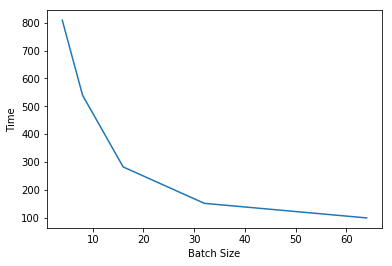

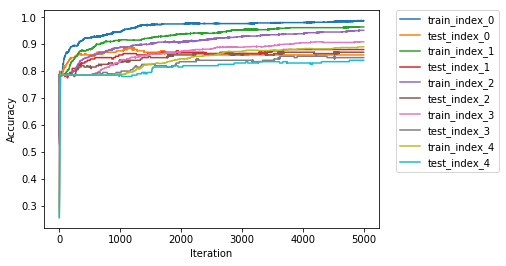

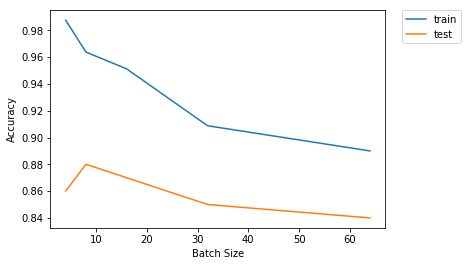

Batch train acc:
[0.9875, 0.9637499928474427, 0.9512500047683716, 0.9087500095367431, 0.8900000095367432]
Batch test acc:
[0.8600000023841858, 0.8799999952316284, 0.8700000047683716, 0.85, 0.8400000095367431]


In [9]:
#plot
plt.figure(7)
plt.plot(batch_size, batch_time,label="time")
plt.xlabel('Batch Size')
plt.ylabel('Time')
plt.show()    
     
plt.figure(8)
plt.plot(range(epochs), batch_train_acc[0],label="train_index_0")
plt.plot(range(epochs), batch_test_acc[0],label="test_index_0")
plt.plot(range(epochs), batch_train_acc[1],label="train_index_1")
plt.plot(range(epochs), batch_test_acc[1],label="test_index_1")
plt.plot(range(epochs), batch_train_acc[2],label="train_index_2")
plt.plot(range(epochs), batch_test_acc[2],label="test_index_2")
plt.plot(range(epochs), batch_train_acc[3],label="train_index_3")
plt.plot(range(epochs), batch_test_acc[3],label="test_index_3")
plt.plot(range(epochs), batch_train_acc[4],label="train_index_4")
plt.plot(range(epochs), batch_test_acc[4],label="test_index_4")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

list_batch_train_acc = [batch_train_acc[0][-1],batch_train_acc[1][-1],batch_train_acc[2][-1],batch_train_acc[3][-1],batch_train_acc[4][-1]]
list_batch_test_acc = [batch_test_acc[0][-1],batch_test_acc[1][-1],batch_test_acc[2][-1],batch_test_acc[3][-1],batch_test_acc[4][-1]]

plt.figure(10)
plt.plot(batch_size,list_batch_train_acc,label="train")
plt.plot(batch_size,list_batch_test_acc,label="test")
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
plt.show()

print('Batch train acc:')
print(list_batch_train_acc)
print('Batch test acc:')
print(list_batch_test_acc)

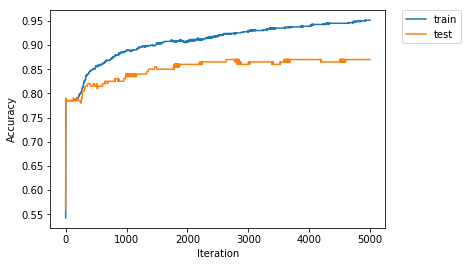

In [10]:
#chosen parameter
plt.figure(8)
plt.plot(range(epochs), batch_train_acc[2],label="train")
plt.plot(range(epochs), batch_test_acc[2],label="test")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [12]:
#set batch size as chosen
#now moving on to neuron analysis
batch_size = 16
num_neurons = [5,10,15,20,25]

#initialization
neuron_time = []
neuron_train_acc = np.zeros((len(num_neurons),epochs))
neuron_test_acc = np.zeros((len(num_neurons),epochs))
X,Y = sample_X,sample_Y

counter = 0
for no_neurons in num_neurons: 
        
        start_time = time.time() #time keeper
        train_acc_= np.zeros((no_folds,epochs))
        test_acc_= np.zeros((no_folds,epochs))
        
        for fold in range(no_folds): 
            start, end = int(fold*len(X)/no_folds), int((fold+1)*len(X)/no_folds)
            testX, testY = X[start:end], Y[start:end]
            trainX  = np.append(X[:start], X[end:], axis=0)
            trainY = np.append(Y[:start], Y[end:], axis=0) 
        
        
            x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
            y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

            n = trainX.shape[0]

            # Create the model

            w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, no_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
            b1  = tf.Variable(tf.zeros([no_neurons]), name='biases')
            u1 = tf.matmul(x, w1) + b1
            h1 = tf.nn.relu(u1)
            w2 = tf.Variable(tf.truncated_normal([no_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(no_neurons))), name='weights')
            b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
            y = tf.matmul(h1, w2) + b2
            
            # Build the graph for the deep net

            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y)
            regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) 
            loss = tf.reduce_mean(cross_entropy + beta*regularization)
            
            # Create the gradient descent optimizer with the given learning rate.
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            train_op = optimizer.minimize(loss)

            correct_prediction = tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32)
            accuracy = tf.reduce_mean(correct_prediction)
        
            # train
            with tf.Session() as sess:
                tf.global_variables_initializer().run()
                train_acc = []
                test_acc = []
                for i in range(epochs):
                    for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
                        train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
                    train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
                    test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
                    if i % 500 == 0:
                        print('iter %d: train accuracy %g test accuracy %g'%(i, train_acc[i],test_acc[i]))  
                        
            train_acc_[fold] = train_acc
            test_acc_[fold] = test_acc
        
        end_time = time.time()
        elapsed = end_time - start_time
        print('Time elapsed - number of neurons = %d: %g' %(no_neurons,elapsed))
            
        neuron_time.append(elapsed)
        neuron_train_acc[counter] = np.mean(train_acc_,axis = 0)
        neuron_test_acc[counter] = np.mean(test_acc_, axis = 0)
        counter = counter + 1

iter 0: train accuracy 0.125 test accuracy 0.2
iter 500: train accuracy 0.8625 test accuracy 0.8
iter 1000: train accuracy 0.8875 test accuracy 0.825
iter 1500: train accuracy 0.91875 test accuracy 0.825
iter 2000: train accuracy 0.925 test accuracy 0.825
iter 2500: train accuracy 0.91875 test accuracy 0.825
iter 3000: train accuracy 0.9125 test accuracy 0.825
iter 3500: train accuracy 0.91875 test accuracy 0.85
iter 4000: train accuracy 0.925 test accuracy 0.85
iter 4500: train accuracy 0.925 test accuracy 0.825
iter 0: train accuracy 0.08125 test accuracy 0
iter 500: train accuracy 0.84375 test accuracy 0.925
iter 1000: train accuracy 0.85625 test accuracy 0.975
iter 1500: train accuracy 0.90625 test accuracy 0.975
iter 2000: train accuracy 0.90625 test accuracy 0.975
iter 2500: train accuracy 0.91875 test accuracy 0.975
iter 3000: train accuracy 0.91875 test accuracy 0.975
iter 3500: train accuracy 0.925 test accuracy 0.975
iter 4000: train accuracy 0.925 test accuracy 0.975
iter 45

iter 3000: train accuracy 0.95 test accuracy 0.85
iter 3500: train accuracy 0.975 test accuracy 0.875
iter 4000: train accuracy 0.98125 test accuracy 0.875
iter 4500: train accuracy 0.98125 test accuracy 0.85
iter 0: train accuracy 0.7625 test accuracy 0.775
iter 500: train accuracy 0.85625 test accuracy 0.95
iter 1000: train accuracy 0.88125 test accuracy 0.95
iter 1500: train accuracy 0.8875 test accuracy 0.95
iter 2000: train accuracy 0.9125 test accuracy 0.95
iter 2500: train accuracy 0.9125 test accuracy 0.975
iter 3000: train accuracy 0.91875 test accuracy 0.975
iter 3500: train accuracy 0.9375 test accuracy 0.975
iter 4000: train accuracy 0.95 test accuracy 0.975
iter 4500: train accuracy 0.9625 test accuracy 0.975
iter 0: train accuracy 0.35 test accuracy 0.375
iter 500: train accuracy 0.875 test accuracy 0.875
iter 1000: train accuracy 0.9 test accuracy 0.9
iter 1500: train accuracy 0.91875 test accuracy 0.9
iter 2000: train accuracy 0.925 test accuracy 0.9
iter 2500: train ac

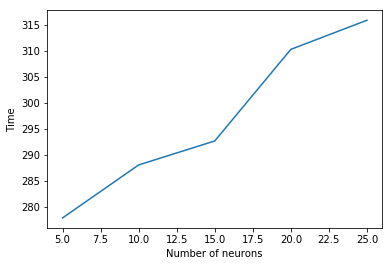

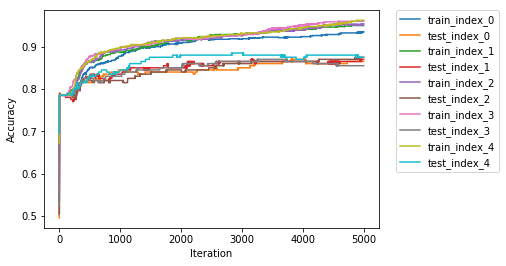

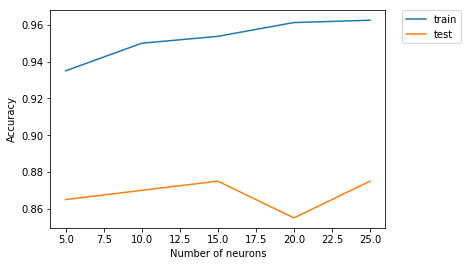

Neuron train acc:
[0.9349999904632569, 0.949999988079071, 0.9537500023841858, 0.9612499952316285, 0.9625]
Neuron test acc:
[0.8650000095367432, 0.8700000047683716, 0.875, 0.8550000071525574, 0.8750000119209289]


In [13]:
plt.figure(9)
plt.plot(num_neurons, neuron_time,label="time")
plt.xlabel('Number of neurons')
plt.ylabel('Time')
plt.show()    
 
plt.figure(8)
plt.plot(range(epochs), neuron_train_acc[0],label="train_index_0")
plt.plot(range(epochs), neuron_test_acc[0],label="test_index_0")
plt.plot(range(epochs), neuron_train_acc[1],label="train_index_1")
plt.plot(range(epochs), neuron_test_acc[1],label="test_index_1")
plt.plot(range(epochs), neuron_train_acc[2],label="train_index_2")
plt.plot(range(epochs), neuron_test_acc[2],label="test_index_2")
plt.plot(range(epochs), neuron_train_acc[3],label="train_index_3")
plt.plot(range(epochs), neuron_test_acc[3],label="test_index_3")
plt.plot(range(epochs), neuron_train_acc[4],label="train_index_4")
plt.plot(range(epochs), neuron_test_acc[4],label="test_index_4")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

list_neuron_train_acc = [neuron_train_acc[0][-1],neuron_train_acc[1][-1],neuron_train_acc[2][-1],neuron_train_acc[3][-1],neuron_train_acc[4][-1]]
list_neuron_test_acc = [neuron_test_acc[0][-1],neuron_test_acc[1][-1],neuron_test_acc[2][-1],neuron_test_acc[3][-1],neuron_test_acc[4][-1]]
    
    
plt.figure(10)
plt.plot(num_neurons, list_neuron_train_acc,label="train")
plt.plot(num_neurons, list_neuron_test_acc,label="test")
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
plt.show()  

print('Neuron train acc:')
print(list_neuron_train_acc)
print('Neuron test acc:')
print(list_neuron_test_acc)

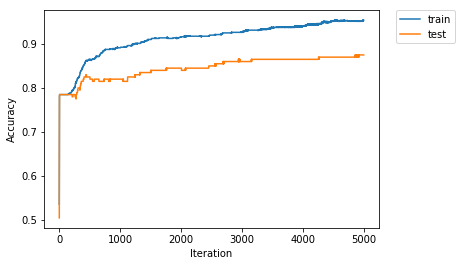

In [21]:
#chosen parameter
plt.figure(8)
plt.plot(range(epochs), neuron_train_acc[2],label="train")
plt.plot(range(epochs), neuron_test_acc[2],label="test")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [18]:
num_neurons = 15
beta_ = [1,10**-3,10**-6,10**-9,10**-12,0]

beta_time = []
beta_train_acc= np.zeros((len(beta_),epochs))
beta_test_acc= np.zeros((len(beta_),epochs))
X,Y = sample_X,sample_Y

counter = 0

for beta in beta_: 

        start_time = time.time() #time keeper
        train_acc_= np.zeros((no_folds,epochs))
        test_acc_= np.zeros((no_folds,epochs))
        
        for fold in range(no_folds): 
            start, end = int(fold*len(X)/no_folds), int((fold+1)*len(X)/no_folds)
            testX, testY = X[start:end], Y[start:end]
            trainX  = np.append(X[:start], X[end:], axis=0)
            trainY = np.append(Y[:start], Y[end:], axis=0) 
        
        
            x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
            y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

            n = trainX.shape[0]

            # Create the model

            w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
            b1  = tf.Variable(tf.zeros([num_neurons]), name='biases')
            u1 = tf.matmul(x, w1) + b1
            h1 = tf.nn.relu(u1)
            w2 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(num_neurons))), name='weights')
            b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
            y = tf.matmul(h1, w2) + b2
            
            # Build the graph for the deep net
	
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y)
            regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
            loss = tf.reduce_mean(cross_entropy + beta*regularization)
            
            # Create the gradient descent optimizer with the given learning rate.
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            train_op = optimizer.minimize(loss)

            correct_prediction = tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32)
            accuracy = tf.reduce_mean(correct_prediction)
        
            # train
            with tf.Session() as sess:
                tf.global_variables_initializer().run()
                train_acc = []
                test_acc = []
                for i in range(epochs):
                    for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
                        train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
                    train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
                    test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
                    if i % 500 == 0:
                        print('iter %d: train accuracy %g test accuracy %g'%(i, train_acc[i],test_acc[i]))  
                        
            train_acc_[fold] = train_acc
            test_acc_[fold] = test_acc
        
        end_time = time.time()
        elapsed = end_time - start_time
        print('Time elapsed - beta = %g: %g' %(beta,elapsed))
            
        beta_time.append(elapsed)
        beta_train_acc[counter] = np.mean(train_acc_,axis = 0)
        beta_test_acc[counter] = np.mean(test_acc_, axis = 0)
        counter = counter + 1

iter 0: train accuracy 0.79375 test accuracy 0.7
iter 500: train accuracy 0.8 test accuracy 0.725
iter 1000: train accuracy 0.8 test accuracy 0.725
iter 1500: train accuracy 0.8 test accuracy 0.725
iter 2000: train accuracy 0.8 test accuracy 0.725
iter 2500: train accuracy 0.8 test accuracy 0.725
iter 3000: train accuracy 0.8 test accuracy 0.725
iter 3500: train accuracy 0.8 test accuracy 0.725
iter 4000: train accuracy 0.8 test accuracy 0.725
iter 4500: train accuracy 0.8 test accuracy 0.725
iter 0: train accuracy 0.55 test accuracy 0.7
iter 500: train accuracy 0.7625 test accuracy 0.875
iter 1000: train accuracy 0.7625 test accuracy 0.875
iter 1500: train accuracy 0.7625 test accuracy 0.875
iter 2000: train accuracy 0.7625 test accuracy 0.875
iter 2500: train accuracy 0.7625 test accuracy 0.875
iter 3000: train accuracy 0.7625 test accuracy 0.875
iter 3500: train accuracy 0.7625 test accuracy 0.875
iter 4000: train accuracy 0.7625 test accuracy 0.875
iter 4500: train accuracy 0.7625 

iter 3000: train accuracy 0.94375 test accuracy 0.85
iter 3500: train accuracy 0.94375 test accuracy 0.875
iter 4000: train accuracy 0.95 test accuracy 0.9
iter 4500: train accuracy 0.95 test accuracy 0.875
iter 0: train accuracy 0.1625 test accuracy 0.125
iter 500: train accuracy 0.85625 test accuracy 0.925
iter 1000: train accuracy 0.86875 test accuracy 0.925
iter 1500: train accuracy 0.88125 test accuracy 0.925
iter 2000: train accuracy 0.90625 test accuracy 0.925
iter 2500: train accuracy 0.9125 test accuracy 0.925
iter 3000: train accuracy 0.9375 test accuracy 0.95
iter 3500: train accuracy 0.93125 test accuracy 0.975
iter 4000: train accuracy 0.93125 test accuracy 0.975
iter 4500: train accuracy 0.95625 test accuracy 0.975
iter 0: train accuracy 0.19375 test accuracy 0.05
iter 500: train accuracy 0.86875 test accuracy 0.875
iter 1000: train accuracy 0.89375 test accuracy 0.9
iter 1500: train accuracy 0.91875 test accuracy 0.9
iter 2000: train accuracy 0.9375 test accuracy 0.9
ite

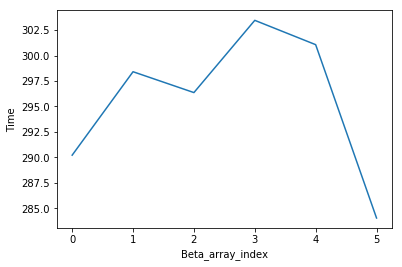

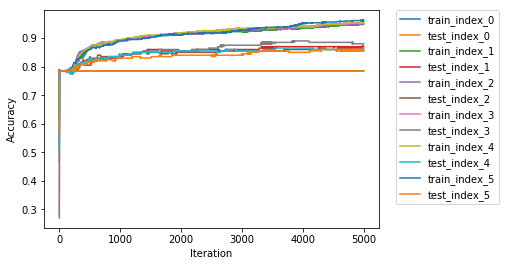

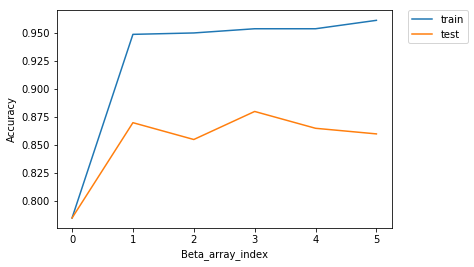

Beta train acc:
[0.7850000023841858, 0.9487499952316284, 0.95, 0.9537500023841858, 0.9537499904632568, 0.9612500071525574]
Beta test acc:
[0.7850000023841858, 0.8700000047683716, 0.8549999952316284, 0.8799999952316284, 0.8649999976158143, 0.8600000023841858]


In [20]:
beta_index = np.arange(len(beta_))

plt.figure(11)
plt.plot(beta_index, beta_time,label="time")
plt.xlabel('Beta_array_index')
plt.ylabel('Time')
plt.show()      
 
plt.figure(8)
plt.plot(range(epochs), beta_train_acc[0],label="train_index_0")
plt.plot(range(epochs), beta_test_acc[0],label="test_index_0")
plt.plot(range(epochs), beta_train_acc[1],label="train_index_1")
plt.plot(range(epochs), beta_test_acc[1],label="test_index_1")
plt.plot(range(epochs), beta_train_acc[2],label="train_index_2")
plt.plot(range(epochs), beta_test_acc[2],label="test_index_2")
plt.plot(range(epochs), beta_train_acc[3],label="train_index_3")
plt.plot(range(epochs), beta_test_acc[3],label="test_index_3")
plt.plot(range(epochs), beta_train_acc[4],label="train_index_4")
plt.plot(range(epochs), beta_test_acc[4],label="test_index_4")
plt.plot(range(epochs), beta_train_acc[5],label="train_index_5")
plt.plot(range(epochs), beta_test_acc[5],label="test_index_5")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

list_beta_train_acc = [beta_train_acc[0][-1],beta_train_acc[1][-1],beta_train_acc[2][-1],beta_train_acc[3][-1],beta_train_acc[4][-1],beta_train_acc[5][-1]]
list_beta_test_acc = [beta_test_acc[0][-1],beta_test_acc[1][-1],beta_test_acc[2][-1],beta_test_acc[3][-1],beta_test_acc[4][-1],beta_test_acc[5][-1]]
    
    
plt.figure(10)
plt.plot(beta_index, list_beta_train_acc,label="train")
plt.plot(beta_index, list_beta_test_acc,label="test")
plt.xlabel('Beta_array_index')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show() 

print('Beta train acc:')
print(list_beta_train_acc)
print('Beta test acc:')
print(list_beta_test_acc)

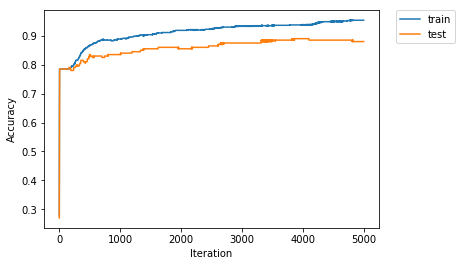

In [24]:
#chosen parameter
plt.figure(8)
plt.plot(range(epochs), beta_train_acc[3],label="train")
plt.plot(range(epochs), beta_test_acc[3],label="test")
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [22]:
layer4_train_acc=np.zeros((no_folds,epochs))
layer4_test_acc=np.zeros((no_folds,epochs))

batch_size = 16
num_neurons = 15
beta_ = 10**-9

X,Y = sample_X,sample_Y

start_time = time.time() #time keeper
for fold in range(no_folds): 
    start, end = int(fold*len(X)/no_folds), int((fold+1)*len(X)/no_folds)
    testX, testY = X[start:end], Y[start:end]
    trainX  = np.append(X[:start], X[end:], axis=0)
    trainY = np.append(Y[:start], Y[end:], axis=0) 
        
        
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    n = trainX.shape[0]

    # Create the model

    w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='weights')
    b1  = tf.Variable(tf.zeros([num_neurons]), name='biases')
    u1 = tf.matmul(x, w1) + b1
    h1 = tf.nn.relu(u1)
    w2 = tf.Variable(tf.truncated_normal([num_neurons, num_neurons], stddev=1.0/math.sqrt(float(num_neurons))), name='weights')
    b2  = tf.Variable(tf.zeros([num_neurons]), name='biases')
    u2 = tf.matmul(h1, w2) + b2
    h2 = tf.nn.relu(u2)
    w3 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(num_neurons))), name='weights')
    b3  = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases')
    y = tf.matmul(h2, w3) + b3
            
    # Build the graph for the deep net
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y)
    regularization = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3)
    loss = tf.reduce_mean(cross_entropy + beta*regularization)
            
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    correct_prediction = tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
        
    # train
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        train_acc = []
        test_acc = []
        for i in range(epochs):
            for start, end in zip(range(0, n, batch_size), range(batch_size, n, batch_size)):
                train_op.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
            train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))
            test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
            if i % 500 == 0:
                print('iter %d: train accuracy %g test accuracy %g'%(i, train_acc[i],test_acc[i]))   
            
    layer4_train_acc[fold] = train_acc
    layer4_test_acc[fold] = test_acc
    
end_time = time.time()
elapsed = end_time - start_time
print('Time elapsed iteration : %g' %(elapsed))

iter 0: train accuracy 0.1875 test accuracy 0.175
iter 500: train accuracy 0.9 test accuracy 0.8
iter 1000: train accuracy 0.925 test accuracy 0.875
iter 1500: train accuracy 0.93125 test accuracy 0.85
iter 2000: train accuracy 0.9625 test accuracy 0.875
iter 2500: train accuracy 0.975 test accuracy 0.825
iter 3000: train accuracy 0.975 test accuracy 0.8
iter 3500: train accuracy 0.98125 test accuracy 0.8
iter 4000: train accuracy 0.975 test accuracy 0.8
iter 4500: train accuracy 0.9875 test accuracy 0.775
iter 0: train accuracy 0.70625 test accuracy 0.85
iter 500: train accuracy 0.85625 test accuracy 0.95
iter 1000: train accuracy 0.89375 test accuracy 0.975
iter 1500: train accuracy 0.94375 test accuracy 0.975
iter 2000: train accuracy 0.95625 test accuracy 0.975
iter 2500: train accuracy 0.95625 test accuracy 0.975
iter 3000: train accuracy 0.975 test accuracy 0.95
iter 3500: train accuracy 0.975 test accuracy 0.95
iter 4000: train accuracy 0.975 test accuracy 0.95
iter 4500: train 

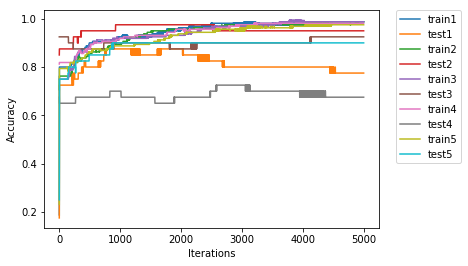

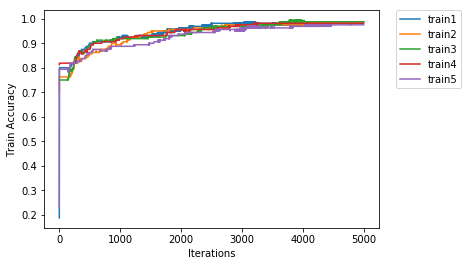

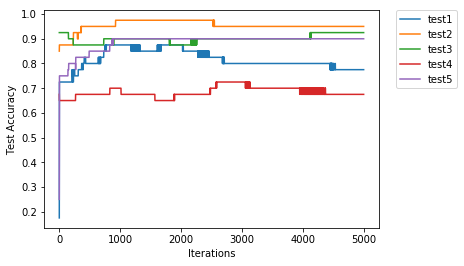

NameError: name 'avg_fold_train_acc' is not defined

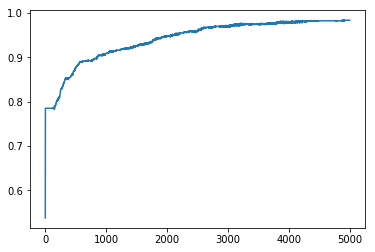

In [23]:
# plot learning curves
        
plt.figure(2)
plt.plot(range(epochs), layer4_train_acc[0],label="train1")
plt.plot(range(epochs), layer4_test_acc[0],label="test1")
plt.plot(range(epochs), layer4_train_acc[1],label="train2")
plt.plot(range(epochs), layer4_test_acc[1],label="test2")
plt.plot(range(epochs), layer4_train_acc[2],label="train3")
plt.plot(range(epochs), layer4_test_acc[2],label="test3")
plt.plot(range(epochs), layer4_train_acc[3],label="train4")
plt.plot(range(epochs), layer4_test_acc[3],label="test4")
plt.plot(range(epochs), layer4_train_acc[4],label="train5")
plt.plot(range(epochs), layer4_test_acc[4],label="test5")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
        
plt.figure(3)
plt.plot(range(epochs), layer4_train_acc[0],label="train1")
plt.plot(range(epochs), layer4_train_acc[1],label="train2")
plt.plot(range(epochs), layer4_train_acc[2],label="train3")
plt.plot(range(epochs), layer4_train_acc[3],label="train4")
plt.plot(range(epochs), layer4_train_acc[4],label="train5")
plt.xlabel('Iterations')
plt.ylabel('Train Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
        
plt.figure(4)
plt.plot(range(epochs), layer4_test_acc[0],label="test1")
plt.plot(range(epochs), layer4_test_acc[1],label="test2")
plt.plot(range(epochs), layer4_test_acc[2],label="test3")
plt.plot(range(epochs), layer4_test_acc[3],label="test4")
plt.plot(range(epochs), layer4_test_acc[4],label="test5")
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

avg_layer4_train_acc=np.mean(layer4_train_acc, axis = 0)
avg_layer4_test_acc=np.mean(layer4_test_acc, axis = 0)
        
plt.figure(5)
plt.plot(range(epochs), avg_layer4_train_acc,label="4layer_train")
plt.plot(range(epochs), avg_fold_train_acc,label="3layer_train")
plt.plot(range(epochs), avg_fold_test_acc,label="3layer_test")
plt.plot(range(epochs), avg_layer4_test_acc,label="4layer_test")
plt.xlabel('Iterations')
plt.ylabel('Mean accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [45]:
print(avg_layer4_train_acc)
print(avg_fold_train_acc)
print(avg_fold_test_acc)
print(avg_layer4_test_acc)

[0.57624999 0.7625     0.78375001 ... 0.98375001 0.98375001 0.98375001]
[0.61875    0.64000001 0.66125001 ... 0.93750001 0.93750001 0.93750001]
[0.645      0.665      0.7        ... 0.86000001 0.86000001 0.86000001]
[0.59499999 0.76       0.78499999 ... 0.865      0.865      0.865     ]
